In [46]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [47]:
archivo = 'BRO.csv'

In [48]:
df = pd.read_csv(archivo,  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','kg'])
df.head()

fecha
2016-01-09    574017
2016-01-16    588433
2016-01-23    590953
2016-01-30    600105
2016-02-06    600680
Name: kg, dtype: int64

In [49]:
print(df.index.min())
print(df.index.max())

2016-01-09 00:00:00
2020-12-26 00:00:00


In [50]:
df.describe()

count       260.000000
mean     254428.550000
std      114716.125282
min      105625.000000
25%      195936.250000
50%      223660.000000
75%      266680.250000
max      600680.000000
Name: kg, dtype: float64

In [51]:
meses =df.resample('M').mean()
meses

fecha
2016-01-31    588377.00
2016-02-29    578901.50
2016-03-31    532961.75
2016-04-30    562863.20
2016-05-31    541792.50
2016-06-30    561786.50
2016-07-31    353590.20
2016-08-31    263169.25
2016-09-30    226869.25
2016-10-31    219467.60
2016-11-30    232784.50
2016-12-31    258528.80
2017-01-31    261227.75
2017-02-28    271345.75
2017-03-31    295706.00
2017-04-30    336786.00
2017-05-31    342789.50
2017-06-30    332396.50
2017-07-31    254208.60
2017-08-31    219187.00
2017-09-30    183762.40
2017-10-31    158525.25
2017-11-30    145928.75
2017-12-31    140153.20
2018-01-31    151094.25
2018-02-28    165292.00
2018-03-31    194404.00
2018-04-30    200104.00
2018-05-31    197761.00
2018-06-30    201911.00
2018-07-31    219972.75
2018-08-31    223428.00
2018-09-30    216609.20
2018-10-31    223346.25
2018-11-30    202500.75
2018-12-31    216532.00
2019-01-31    220582.50
2019-02-28    209763.00
2019-03-31    206262.20
2019-04-30    195430.25
2019-05-31    229596.75
2019-06-30

In [52]:
años =df.resample('Y').mean()
años

fecha
2016-12-31    405361.884615
2017-12-31    243903.403846
2018-12-31    201563.019231
2019-12-31    225181.730769
2020-12-31    196132.711538
Freq: A-DEC, Name: kg, dtype: float64

# Se está trabajando por semanas, por lo cual cada año tiene 52 datos

In [53]:
print(len(df['2016']))
print(len(df['2017']))
print(len(df['2018']))
print(len(df['2019']))
print(len(df['2020']))

52
52
52
52
52


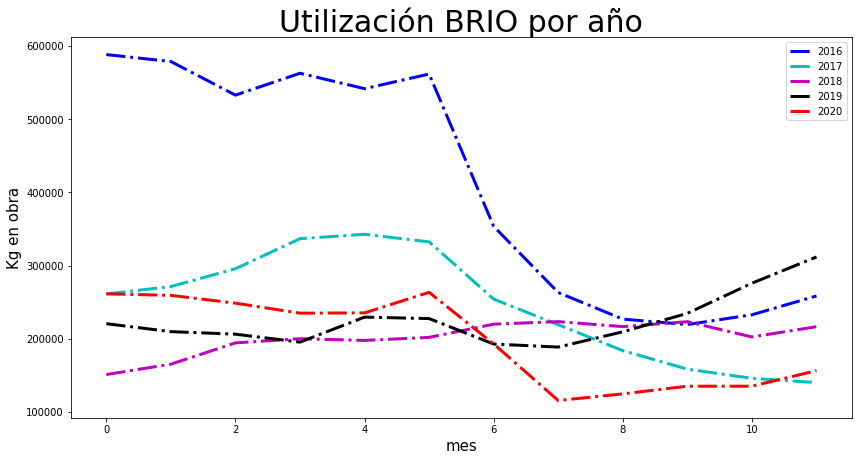

In [54]:
plt.plot(meses['2016'].values,color='b',linewidth=3,linestyle='-.',label="2016")
plt.plot(meses['2017'].values,color="c",linewidth=3,linestyle="-.",label="2017")
plt.plot(meses['2018'].values,color="m",linewidth=3,linestyle="-.",label="2018")
plt.plot(meses['2019'].values,color="k",linewidth=3,linestyle="-.",label="2019")
plt.plot(meses['2020'].values,color="r",linewidth=3,linestyle="-.",label="2020")
plt.xlabel("mes",size= 15)
plt.ylabel("Kg en obra",size= 15)
plt.title("Utilización BRIO por año",size= 30)
plt.legend(['2016','2017','2018','2019','2020'])

Se visualiza que durante todos los años representados, los kilos en obra de orma tienden al alza, por lo cual se analiza en detalle los terminos de año.

Text(0.5, 1.0, 'Utilización último trimestre')

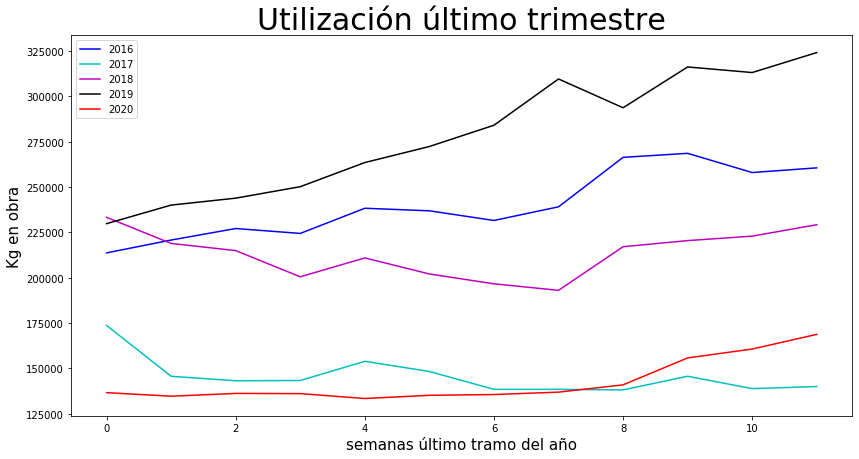

In [55]:
Fin2016 = df['2016-10-15':'2016-12-31']
plt.plot(Fin2016.values,color='b')
Fin2017 = df['2017-10-14':'2017-12-30']
plt.plot(Fin2017.values,color="c")
Fin2018 = df['2018-10-13':'2018-12-29']
plt.plot(Fin2018.values,color="m")
Fin2019 = df['2019-10-12':'2019-12-28']
plt.plot(Fin2019.values,color="k")
Fin2020 = df['2020-10-10':'2020-12-26']
plt.plot(Fin2020.values,color="r")
plt.legend(['2016','2017','2018','2019','2020'])
plt.xlabel("semanas último tramo del año",size= 15)
plt.ylabel("Kg en obra",size= 15)
plt.title("Utilización último trimestre",size= 30)

In [56]:
#pronosticar el 8vo día a partir de la semana anterior
PASOS = 7 
    
# convertir serie a entrenamiento supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de pronóstico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargar data set
values = df.values
# asegurando que los datos sean numeros reales
values = values.astype('float32')
# normalizar para mejorar la eficiencia de la red
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.892283,0.950523,0.960703,0.997677,1.000000,0.881217,0.892177,0.874668
8,0.950523,0.960703,0.997677,1.000000,0.881217,0.892177,0.874668,0.727473
9,0.960703,0.997677,1.000000,0.881217,0.892177,0.874668,0.727473,0.831320
10,0.997677,1.000000,0.881217,0.892177,0.874668,0.727473,0.831320,0.693690
11,1.000000,0.881217,0.892177,0.874668,0.727473,0.831320,0.693690,0.653202


In [57]:
# definir cantidad de datos para entrenar y hacer las pruebas 80-20
values = reframed.values
n_train_days = 260 - (100+PASOS) 
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# desencapsular entramiento y prueba
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# 
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(153, 1, 7) (153,) (100, 1, 7) (100,)


In [58]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [59]:
# se definen la cantidad de iteraciones y el modelo
EPOCHS=4000
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
22/22 [==============================] - 0s 8ms/step - loss: 0.9484 - mse: 1.0556 - val_loss: 0.8507 - val_mse: 0.8233
Epoch 2/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.6723 - mse: 0.5654 - val_loss: 0.4948 - val_mse: 0.3204
Epoch 3/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.3846 - mse: 0.2251 - val_loss: 0.2225 - val_mse:

22/22 [==============================] - 0s 2ms/step - loss: 0.0619 - mse: 0.0129 - val_loss: 0.0632 - val_mse: 0.0073
Epoch 58/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0613 - mse: 0.0127 - val_loss: 0.0631 - val_mse: 0.0074
Epoch 59/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0612 - mse: 0.0125 - val_loss: 0.0626 - val_mse: 0.0072
Epoch 60/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0618 - mse: 0.0126 - val_loss: 0.0632 - val_mse: 0.0071
Epoch 61/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0609 - mse: 0.0126 - val_loss: 0.0622 - val_mse: 0.0072
Epoch 62/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0606 - mse: 0.0125 - val_loss: 0.0648 - val_mse: 0.0071
Epoch 63/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0616 - mse: 0.0127 - val_loss: 0.0624 - val_mse: 0.0074
Epoch 64/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0602 -

22/22 [==============================] - 0s 2ms/step - loss: 0.0522 - mse: 0.0108 - val_loss: 0.0563 - val_mse: 0.0060
Epoch 119/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0525 - mse: 0.0110 - val_loss: 0.0571 - val_mse: 0.0066
Epoch 120/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0517 - mse: 0.0108 - val_loss: 0.0557 - val_mse: 0.0060
Epoch 121/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0516 - mse: 0.0108 - val_loss: 0.0552 - val_mse: 0.0061
Epoch 122/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0517 - mse: 0.0107 - val_loss: 0.0555 - val_mse: 0.0060
Epoch 123/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0526 - mse: 0.0109 - val_loss: 0.0553 - val_mse: 0.0062
Epoch 124/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0523 - mse: 0.0110 - val_loss: 0.0565 - val_mse: 0.0066
Epoch 125/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0493 - mse: 0.0105 - val_loss: 0.0529 - val_mse: 0.0060
Epoch 180/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0479 - mse: 0.0102 - val_loss: 0.0530 - val_mse: 0.0057
Epoch 181/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0473 - mse: 0.0100 - val_loss: 0.0538 - val_mse: 0.0057
Epoch 182/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0472 - mse: 0.0102 - val_loss: 0.0535 - val_mse: 0.0061
Epoch 183/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0463 - mse: 0.0100 - val_loss: 0.0526 - val_mse: 0.0059
Epoch 184/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0464 - mse: 0.0100 - val_loss: 0.0530 - val_mse: 0.0060
Epoch 185/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0462 - mse: 0.0099 - val_loss: 0.0527 - val_mse: 0.0057
Epoch 186/4000
22/22 [==============================] - 0s 3ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0438 - mse: 0.0094 - val_loss: 0.0541 - val_mse: 0.0057
Epoch 241/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0447 - mse: 0.0096 - val_loss: 0.0519 - val_mse: 0.0058
Epoch 242/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0440 - mse: 0.0095 - val_loss: 0.0528 - val_mse: 0.0061
Epoch 243/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0438 - mse: 0.0094 - val_loss: 0.0519 - val_mse: 0.0058
Epoch 244/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0432 - mse: 0.0094 - val_loss: 0.0524 - val_mse: 0.0060
Epoch 245/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0437 - mse: 0.0095 - val_loss: 0.0519 - val_mse: 0.0056
Epoch 246/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0429 - mse: 0.0094 - val_loss: 0.0526 - val_mse: 0.0060
Epoch 247/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 3ms/step - loss: 0.0436 - mse: 0.0092 - val_loss: 0.0527 - val_mse: 0.0057
Epoch 302/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0418 - mse: 0.0092 - val_loss: 0.0533 - val_mse: 0.0063
Epoch 303/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0421 - mse: 0.0092 - val_loss: 0.0519 - val_mse: 0.0058
Epoch 304/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0425 - mse: 0.0093 - val_loss: 0.0521 - val_mse: 0.0057
Epoch 305/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0435 - mse: 0.0094 - val_loss: 0.0521 - val_mse: 0.0057
Epoch 306/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0422 - mse: 0.0092 - val_loss: 0.0517 - val_mse: 0.0058
Epoch 307/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0422 - mse: 0.0092 - val_loss: 0.0518 - val_mse: 0.0059
Epoch 308/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0414 - mse: 0.0091 - val_loss: 0.0520 - val_mse: 0.0060
Epoch 363/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0091 - val_loss: 0.0518 - val_mse: 0.0058
Epoch 364/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0091 - val_loss: 0.0518 - val_mse: 0.0058
Epoch 365/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0091 - val_loss: 0.0524 - val_mse: 0.0061
Epoch 366/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0418 - mse: 0.0092 - val_loss: 0.0517 - val_mse: 0.0058
Epoch 367/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0092 - val_loss: 0.0518 - val_mse: 0.0057
Epoch 368/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0427 - mse: 0.0094 - val_loss: 0.0521 - val_mse: 0.0057
Epoch 369/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0091 - val_loss: 0.0526 - val_mse: 0.0062
Epoch 424/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0092 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 425/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0091 - val_loss: 0.0517 - val_mse: 0.0059
Epoch 426/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0417 - mse: 0.0091 - val_loss: 0.0514 - val_mse: 0.0058
Epoch 427/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0090 - val_loss: 0.0516 - val_mse: 0.0057
Epoch 428/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 429/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0522 - val_mse: 0.0061
Epoch 430/4000
22/22 [==============================] - 0s 3ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0091 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 485/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0413 - mse: 0.0091 - val_loss: 0.0511 - val_mse: 0.0057
Epoch 486/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0419 - mse: 0.0091 - val_loss: 0.0514 - val_mse: 0.0059
Epoch 487/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0091 - val_loss: 0.0514 - val_mse: 0.0057
Epoch 488/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0414 - mse: 0.0090 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 489/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0091 - val_loss: 0.0512 - val_mse: 0.0058
Epoch 490/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0414 - mse: 0.0091 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 491/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0090 - val_loss: 0.0508 - val_mse: 0.0056
Epoch 546/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0509 - val_mse: 0.0056
Epoch 547/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0090 - val_loss: 0.0511 - val_mse: 0.0058
Epoch 548/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0091 - val_loss: 0.0509 - val_mse: 0.0058
Epoch 549/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0411 - mse: 0.0091 - val_loss: 0.0508 - val_mse: 0.0056
Epoch 550/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0091 - val_loss: 0.0526 - val_mse: 0.0056
Epoch 551/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0092 - val_loss: 0.0514 - val_mse: 0.0059
Epoch 552/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0422 - mse: 0.0092 - val_loss: 0.0512 - val_mse: 0.0055
Epoch 607/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0419 - mse: 0.0091 - val_loss: 0.0505 - val_mse: 0.0056
Epoch 608/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0090 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 609/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0506 - val_mse: 0.0056
Epoch 610/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0093 - val_loss: 0.0513 - val_mse: 0.0055
Epoch 611/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0508 - val_mse: 0.0057
Epoch 612/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0408 - mse: 0.0089 - val_loss: 0.0508 - val_mse: 0.0057
Epoch 613/4000
22/22 [==============================] - 0s 3ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0090 - val_loss: 0.0503 - val_mse: 0.0055
Epoch 668/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0089 - val_loss: 0.0507 - val_mse: 0.0055
Epoch 669/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0402 - mse: 0.0089 - val_loss: 0.0528 - val_mse: 0.0062
Epoch 670/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0089 - val_loss: 0.0505 - val_mse: 0.0057
Epoch 671/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0090 - val_loss: 0.0507 - val_mse: 0.0055
Epoch 672/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0411 - mse: 0.0090 - val_loss: 0.0510 - val_mse: 0.0058
Epoch 673/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0090 - val_loss: 0.0516 - val_mse: 0.0055
Epoch 674/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0555 - val_mse: 0.0066
Epoch 729/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0090 - val_loss: 0.0502 - val_mse: 0.0056
Epoch 730/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0413 - mse: 0.0090 - val_loss: 0.0512 - val_mse: 0.0059
Epoch 731/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0089 - val_loss: 0.0500 - val_mse: 0.0055
Epoch 732/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0088 - val_loss: 0.0501 - val_mse: 0.0054
Epoch 733/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0401 - mse: 0.0089 - val_loss: 0.0501 - val_mse: 0.0054
Epoch 734/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0502 - val_mse: 0.0056
Epoch 735/4000
22/22 [==============================] - 0s 2ms/step - loss: 0

Epoch 789/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0501 - val_mse: 0.0056
Epoch 790/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0498 - val_mse: 0.0054
Epoch 791/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0499 - val_mse: 0.0054
Epoch 792/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0498 - val_mse: 0.0055
Epoch 793/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0090 - val_loss: 0.0500 - val_mse: 0.0056
Epoch 794/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0398 - mse: 0.0089 - val_loss: 0.0497 - val_mse: 0.0056
Epoch 795/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0497 - val_mse: 0.0054
Epoch 796/4000
22/22 [==============================] - 0s 3ms

Epoch 850/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0402 - mse: 0.0088 - val_loss: 0.0495 - val_mse: 0.0055
Epoch 851/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0088 - val_loss: 0.0499 - val_mse: 0.0056
Epoch 852/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0089 - val_loss: 0.0494 - val_mse: 0.0054
Epoch 853/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0496 - val_mse: 0.0054
Epoch 854/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0089 - val_loss: 0.0499 - val_mse: 0.0053
Epoch 855/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0398 - mse: 0.0089 - val_loss: 0.0496 - val_mse: 0.0053
Epoch 856/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0399 - mse: 0.0089 - val_loss: 0.0502 - val_mse: 0.0057
Epoch 857/4000
22/22 [==============================] - 0s 2ms

Epoch 911/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0393 - mse: 0.0088 - val_loss: 0.0494 - val_mse: 0.0055
Epoch 912/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0391 - mse: 0.0088 - val_loss: 0.0491 - val_mse: 0.0054
Epoch 913/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0398 - mse: 0.0088 - val_loss: 0.0534 - val_mse: 0.0062
Epoch 914/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0089 - val_loss: 0.0495 - val_mse: 0.0055
Epoch 915/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0088 - val_loss: 0.0494 - val_mse: 0.0053
Epoch 916/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0403 - mse: 0.0088 - val_loss: 0.0515 - val_mse: 0.0059
Epoch 917/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0396 - mse: 0.0088 - val_loss: 0.0493 - val_mse: 0.0053
Epoch 918/4000
22/22 [==============================] - 0s 3ms

22/22 [==============================] - 0s 3ms/step - loss: 0.0390 - mse: 0.0088 - val_loss: 0.0489 - val_mse: 0.0053
Epoch 973/4000
22/22 [==============================] - ETA: 0s - loss: 0.0346 - mse: 0.002 - 0s 2ms/step - loss: 0.0394 - mse: 0.0088 - val_loss: 0.0491 - val_mse: 0.0054
Epoch 974/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0088 - val_loss: 0.0489 - val_mse: 0.0053
Epoch 975/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0392 - mse: 0.0088 - val_loss: 0.0494 - val_mse: 0.0055
Epoch 976/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0397 - mse: 0.0089 - val_loss: 0.0489 - val_mse: 0.0053
Epoch 977/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0088 - val_loss: 0.0489 - val_mse: 0.0053
Epoch 978/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0088 - val_loss: 0.0508 - val_mse: 0.0057
Epoch 979/4000
22/22 [=================

Epoch 1033/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0407 - mse: 0.0087 - val_loss: 0.0538 - val_mse: 0.0061
Epoch 1034/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0089 - val_loss: 0.0491 - val_mse: 0.0052
Epoch 1035/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0090 - val_loss: 0.0490 - val_mse: 0.0052
Epoch 1036/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0089 - val_loss: 0.0489 - val_mse: 0.0052
Epoch 1037/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0391 - mse: 0.0087 - val_loss: 0.0490 - val_mse: 0.0054
Epoch 1038/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0402 - mse: 0.0089 - val_loss: 0.0492 - val_mse: 0.0055
Epoch 1039/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0087 - val_loss: 0.0488 - val_mse: 0.0054
Epoch 1040/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0088 - val_loss: 0.0502 - val_mse: 0.0056
Epoch 1094/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0089 - val_loss: 0.0486 - val_mse: 0.0053
Epoch 1095/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0087 - val_loss: 0.0489 - val_mse: 0.0051
Epoch 1096/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0087 - val_loss: 0.0493 - val_mse: 0.0051
Epoch 1097/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0088 - val_loss: 0.0484 - val_mse: 0.0052
Epoch 1098/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0088 - val_loss: 0.0489 - val_mse: 0.0054
Epoch 1099/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0087 - val_loss: 0.0484 - val_mse: 0.0052
Epoch 1100/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1154/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0088 - val_loss: 0.0483 - val_mse: 0.0051
Epoch 1155/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0087 - val_loss: 0.0482 - val_mse: 0.0051
Epoch 1156/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0483 - val_mse: 0.0053
Epoch 1157/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.0088 - val_loss: 0.0504 - val_mse: 0.0056
Epoch 1158/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0404 - mse: 0.0089 - val_loss: 0.0500 - val_mse: 0.0056
Epoch 1159/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0397 - mse: 0.0089 - val_loss: 0.0486 - val_mse: 0.0051
Epoch 1160/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0089 - val_loss: 0.0486 - val_mse: 0.0051
Epoch 1161/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.0087 - val_loss: 0.0486 - val_mse: 0.0050
Epoch 1215/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0399 - mse: 0.0089 - val_loss: 0.0480 - val_mse: 0.0052
Epoch 1216/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.0092 - val_loss: 0.0559 - val_mse: 0.0063
Epoch 1217/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0411 - mse: 0.0089 - val_loss: 0.0514 - val_mse: 0.0058
Epoch 1218/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0393 - mse: 0.0088 - val_loss: 0.0480 - val_mse: 0.0051
Epoch 1219/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0086 - val_loss: 0.0507 - val_mse: 0.0057
Epoch 1220/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0088 - val_loss: 0.0481 - val_mse: 0.0051
Epoch 1221/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1275/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0395 - mse: 0.0087 - val_loss: 0.0485 - val_mse: 0.0053
Epoch 1276/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0087 - val_loss: 0.0501 - val_mse: 0.0056
Epoch 1277/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0480 - val_mse: 0.0050
Epoch 1278/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0404 - mse: 0.0088 - val_loss: 0.0479 - val_mse: 0.0051
Epoch 1279/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0420 - mse: 0.0090 - val_loss: 0.0479 - val_mse: 0.0051
Epoch 1280/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0087 - val_loss: 0.0491 - val_mse: 0.0054
Epoch 1281/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0088 - val_loss: 0.0487 - val_mse: 0.0054
Epoch 1282/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0086 - val_loss: 0.0477 - val_mse: 0.0051
Epoch 1336/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0088 - val_loss: 0.0504 - val_mse: 0.0056
Epoch 1337/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0086 - val_loss: 0.0478 - val_mse: 0.0052
Epoch 1338/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0481 - val_mse: 0.0050
Epoch 1339/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0086 - val_loss: 0.0477 - val_mse: 0.0050
Epoch 1340/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0086 - val_loss: 0.0478 - val_mse: 0.0051
Epoch 1341/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0402 - mse: 0.0089 - val_loss: 0.0478 - val_mse: 0.0052
Epoch 1342/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1396/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0477 - val_mse: 0.0051
Epoch 1397/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0477 - val_mse: 0.0051
Epoch 1398/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0478 - val_mse: 0.0051
Epoch 1399/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0086 - val_loss: 0.0475 - val_mse: 0.0050
Epoch 1400/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0087 - val_loss: 0.0475 - val_mse: 0.0050
Epoch 1401/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0485 - val_mse: 0.0053
Epoch 1402/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0087 - val_loss: 0.0482 - val_mse: 0.0052
Epoch 1403/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0484 - val_mse: 0.0050
Epoch 1457/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0088 - val_loss: 0.0484 - val_mse: 0.0053
Epoch 1458/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0085 - val_loss: 0.0473 - val_mse: 0.0049
Epoch 1459/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 1460/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0087 - val_loss: 0.0475 - val_mse: 0.0051
Epoch 1461/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0475 - val_mse: 0.0051
Epoch 1462/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0477 - val_mse: 0.0052
Epoch 1463/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1517/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0086 - val_loss: 0.0483 - val_mse: 0.0053
Epoch 1518/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0473 - val_mse: 0.0049
Epoch 1519/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0086 - val_loss: 0.0473 - val_mse: 0.0050
Epoch 1520/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0474 - val_mse: 0.0050
Epoch 1521/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0086 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 1522/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0086 - val_loss: 0.0518 - val_mse: 0.0057
Epoch 1523/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.0086 - val_loss: 0.0472 - val_mse: 0.0049
Epoch 1524/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0087 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 1578/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0086 - val_loss: 0.0503 - val_mse: 0.0055
Epoch 1579/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0392 - mse: 0.0087 - val_loss: 0.0505 - val_mse: 0.0055
Epoch 1580/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0085 - val_loss: 0.0470 - val_mse: 0.0049
Epoch 1581/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0086 - val_loss: 0.0472 - val_mse: 0.0049
Epoch 1582/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0485 - val_mse: 0.0053
Epoch 1583/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0086 - val_loss: 0.0471 - val_mse: 0.0049
Epoch 1584/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1638/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0087 - val_loss: 0.0486 - val_mse: 0.0053
Epoch 1639/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0087 - val_loss: 0.0471 - val_mse: 0.0049
Epoch 1640/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0498 - val_mse: 0.0050
Epoch 1641/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0089 - val_loss: 0.0475 - val_mse: 0.0049
Epoch 1642/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0088 - val_loss: 0.0472 - val_mse: 0.0049
Epoch 1643/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0085 - val_loss: 0.0471 - val_mse: 0.0050
Epoch 1644/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0392 - mse: 0.0086 - val_loss: 0.0504 - val_mse: 0.0055
Epoch 1645/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0474 - val_mse: 0.0051
Epoch 1699/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0470 - val_mse: 0.0050
Epoch 1700/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0084 - val_loss: 0.0546 - val_mse: 0.0060
Epoch 1701/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0087 - val_loss: 0.0495 - val_mse: 0.0054
Epoch 1702/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0085 - val_loss: 0.0477 - val_mse: 0.0052
Epoch 1703/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0085 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 1704/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0086 - val_loss: 0.0468 - val_mse: 0.0049
Epoch 1705/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1759/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0468 - val_mse: 0.0049
Epoch 1760/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0474 - val_mse: 0.0051
Epoch 1761/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0086 - val_loss: 0.0494 - val_mse: 0.0054
Epoch 1762/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.0087 - val_loss: 0.0488 - val_mse: 0.0053
Epoch 1763/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0086 - val_loss: 0.0484 - val_mse: 0.0053
Epoch 1764/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0085 - val_loss: 0.0468 - val_mse: 0.0048
Epoch 1765/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0086 - val_loss: 0.0499 - val_mse: 0.0054
Epoch 1766/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 1820/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0086 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 1821/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0084 - val_loss: 0.0484 - val_mse: 0.0052
Epoch 1822/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0468 - val_mse: 0.0049
Epoch 1823/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0086 - val_loss: 0.0477 - val_mse: 0.0048
Epoch 1824/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 1825/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0048
Epoch 1826/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 1880/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0086 - val_loss: 0.0489 - val_mse: 0.0052
Epoch 1881/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0086 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 1882/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0048
Epoch 1883/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 1884/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0086 - val_loss: 0.0474 - val_mse: 0.0048
Epoch 1885/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0089 - val_loss: 0.0478 - val_mse: 0.0052
Epoch 1886/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0086 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 1887/4000
22/22 [==============================] 

22/22 [==============================] - 0s 3ms/step - loss: 0.0390 - mse: 0.0085 - val_loss: 0.0469 - val_mse: 0.0048
Epoch 1941/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0086 - val_loss: 0.0471 - val_mse: 0.0050
Epoch 1942/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0469 - val_mse: 0.0048
Epoch 1943/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0470 - val_mse: 0.0050
Epoch 1944/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 1945/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0380 - mse: 0.0085 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 1946/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 1947/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 2001/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 2002/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0465 - val_mse: 0.0048
Epoch 2003/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0468 - val_mse: 0.0050
Epoch 2004/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0465 - val_mse: 0.0048
Epoch 2005/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0380 - mse: 0.0086 - val_loss: 0.0467 - val_mse: 0.0048
Epoch 2006/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0386 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2007/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0475 - val_mse: 0.0051
Epoch 2008/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0086 - val_loss: 0.0475 - val_mse: 0.0051
Epoch 2062/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0086 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 2063/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 2064/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0465 - val_mse: 0.0048
Epoch 2065/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0464 - val_mse: 0.0048
Epoch 2066/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0464 - val_mse: 0.0048
Epoch 2067/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0482 - val_mse: 0.0052
Epoch 2068/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 2122/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0085 - val_loss: 0.0465 - val_mse: 0.0049
Epoch 2123/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0085 - val_loss: 0.0465 - val_mse: 0.0049
Epoch 2124/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0471 - val_mse: 0.0050
Epoch 2125/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0467 - val_mse: 0.0047
Epoch 2126/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0085 - val_loss: 0.0462 - val_mse: 0.0048
Epoch 2127/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0509 - val_mse: 0.0055
Epoch 2128/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0084 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2129/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0087 - val_loss: 0.0463 - val_mse: 0.0048
Epoch 2183/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0048
Epoch 2184/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0462 - val_mse: 0.0047
Epoch 2185/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0085 - val_loss: 0.0479 - val_mse: 0.0052
Epoch 2186/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0474 - val_mse: 0.0051
Epoch 2187/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0048
Epoch 2188/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0466 - val_mse: 0.0047
Epoch 2189/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 2243/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0462 - val_mse: 0.0047
Epoch 2244/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0086 - val_loss: 0.0462 - val_mse: 0.0047
Epoch 2245/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0086 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2246/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0462 - val_mse: 0.0048
Epoch 2247/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0462 - val_mse: 0.0048
Epoch 2248/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0387 - mse: 0.0086 - val_loss: 0.0462 - val_mse: 0.0048
Epoch 2249/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0085 - val_loss: 0.0462 - val_mse: 0.0048
Epoch 2250/4000
22/22 [==============================] 

22/22 [==============================] - 0s 3ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0490 - val_mse: 0.0053
Epoch 2304/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0386 - mse: 0.0085 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 2305/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 2306/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0386 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2307/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0085 - val_loss: 0.0465 - val_mse: 0.0049
Epoch 2308/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0047
Epoch 2309/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0086 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2310/4000
22/22 [==============================] - 0s 3ms/step - 

Epoch 2364/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0397 - mse: 0.0086 - val_loss: 0.0488 - val_mse: 0.0052
Epoch 2365/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 2366/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2367/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2368/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0494 - val_mse: 0.0053
Epoch 2369/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0047
Epoch 2370/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0085 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 2371/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2425/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 2426/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 2427/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0047
Epoch 2428/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0047
Epoch 2429/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0084 - val_loss: 0.0470 - val_mse: 0.0047
Epoch 2430/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 2431/4000
22/22 [==============================] - 0s 3ms/step - 

22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 2485/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0526 - val_mse: 0.0057
Epoch 2486/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2487/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 2488/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 2489/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2490/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0463 - val_mse: 0.0047
Epoch 2491/4000
22/22 [==============================] - 0s 3ms/step - 

Epoch 2545/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 2546/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0479 - val_mse: 0.0052
Epoch 2547/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 2548/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0471 - val_mse: 0.0050
Epoch 2549/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 2550/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0375 - mse: 0.0084 - val_loss: 0.0464 - val_mse: 0.0047
Epoch 2551/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0467 - val_mse: 0.0050
Epoch 2552/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0085 - val_loss: 0.0460 - val_mse: 0.0047
Epoch 2606/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0047
Epoch 2607/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 2608/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0047
Epoch 2609/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 2610/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0085 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 2611/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0086 - val_loss: 0.0494 - val_mse: 0.0053
Epoch 2612/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 2666/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 2667/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0085 - val_loss: 0.0477 - val_mse: 0.0050
Epoch 2668/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0466 - val_mse: 0.0047
Epoch 2669/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0398 - mse: 0.0086 - val_loss: 0.0472 - val_mse: 0.0047
Epoch 2670/4000
22/22 [==============================] - ETA: 0s - loss: 0.1772 - mse: 0.147 - 0s 3ms/step - loss: 0.0405 - mse: 0.0087 - val_loss: 0.0481 - val_mse: 0.0048
Epoch 2671/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0410 - mse: 0.0088 - val_loss: 0.0489 - val_mse: 0.0052
Epoch 2672/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0468 - val_mse: 0.0050
Epoch 2673/4000
2

22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 2727/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0083 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 2728/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 2729/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0086 - val_loss: 0.0476 - val_mse: 0.0047
Epoch 2730/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0086 - val_loss: 0.0474 - val_mse: 0.0047
Epoch 2731/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 2732/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 2733/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 2787/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0083 - val_loss: 0.0459 - val_mse: 0.0047
Epoch 2788/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0083 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 2789/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0373 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0047
Epoch 2790/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 2791/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0473 - val_mse: 0.0050
Epoch 2792/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 2793/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 2794/4000
22/22 [==============================] 

22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0487 - val_mse: 0.0052
Epoch 2848/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0387 - mse: 0.0084 - val_loss: 0.0502 - val_mse: 0.0054
Epoch 2849/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0383 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 2850/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0468 - val_mse: 0.0049
Epoch 2851/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 2852/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0467 - val_mse: 0.0049
Epoch 2853/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 2854/4000
22/22 [==============================] - 0s 3ms/step - 

Epoch 2908/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0084 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 2909/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 2910/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 2911/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 2912/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0083 - val_loss: 0.0517 - val_mse: 0.0055
Epoch 2913/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.0084 - val_loss: 0.0483 - val_mse: 0.0051
Epoch 2914/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0047
Epoch 2915/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 2969/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0485 - val_mse: 0.0052
Epoch 2970/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0380 - mse: 0.0085 - val_loss: 0.0489 - val_mse: 0.0052
Epoch 2971/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0380 - mse: 0.0083 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 2972/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 2973/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0459 - val_mse: 0.0047
Epoch 2974/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0392 - mse: 0.0085 - val_loss: 0.0463 - val_mse: 0.0047
Epoch 2975/4000
22/22 [==============================] - 0s 3ms/step - 

Epoch 3029/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0083 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 3030/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0085 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 3031/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 3032/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3033/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0084 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 3034/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 3035/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0047
Epoch 3036/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0401 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 3090/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0084 - val_loss: 0.0475 - val_mse: 0.0051
Epoch 3091/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0085 - val_loss: 0.0461 - val_mse: 0.0048
Epoch 3092/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0084 - val_loss: 0.0466 - val_mse: 0.0050
Epoch 3093/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0085 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3094/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0395 - mse: 0.0084 - val_loss: 0.0461 - val_mse: 0.0047
Epoch 3095/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0459 - val_mse: 0.0047
Epoch 3096/4000
22/22 [==============================] - 0s 3ms/step - 

Epoch 3150/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0085 - val_loss: 0.0468 - val_mse: 0.0050
Epoch 3151/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0086 - val_loss: 0.0487 - val_mse: 0.0051
Epoch 3152/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0050
Epoch 3153/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0395 - mse: 0.0086 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 3154/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3155/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0083 - val_loss: 0.0466 - val_mse: 0.0046
Epoch 3156/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3157/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0084 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 3211/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0084 - val_loss: 0.0497 - val_mse: 0.0053
Epoch 3212/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0476 - val_mse: 0.0051
Epoch 3213/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0085 - val_loss: 0.0477 - val_mse: 0.0051
Epoch 3214/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0084 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 3215/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0084 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 3216/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0047
Epoch 3217/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3271/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0046
Epoch 3272/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0046
Epoch 3273/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0083 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 3274/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0082 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3275/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3276/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0083 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 3277/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3278/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3332/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0085 - val_loss: 0.0470 - val_mse: 0.0047
Epoch 3333/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0085 - val_loss: 0.0484 - val_mse: 0.0051
Epoch 3334/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0083 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 3335/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3336/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3337/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0082 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 3338/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3392/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3393/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3394/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3395/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0083 - val_loss: 0.0462 - val_mse: 0.0049
Epoch 3396/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0046
Epoch 3397/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0083 - val_loss: 0.0469 - val_mse: 0.0050
Epoch 3398/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 3399/4000
22/22 [==============================] 

22/22 [==============================] - 0s 3ms/step - loss: 0.0378 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3453/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0372 - mse: 0.0083 - val_loss: 0.0462 - val_mse: 0.0046
Epoch 3454/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 3455/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0082 - val_loss: 0.0464 - val_mse: 0.0049
Epoch 3456/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0378 - mse: 0.0083 - val_loss: 0.0517 - val_mse: 0.0055
Epoch 3457/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3458/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 3459/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3513/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 3514/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 3515/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0083 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3516/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0083 - val_loss: 0.0487 - val_mse: 0.0052
Epoch 3517/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 3518/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3519/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0370 - mse: 0.0083 - val_loss: 0.0459 - val_mse: 0.0048
Epoch 3520/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0084 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3574/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0482 - val_mse: 0.0051
Epoch 3575/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3576/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3577/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0085 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3578/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3579/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3580/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3634/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0474 - val_mse: 0.0050
Epoch 3635/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0083 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 3636/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0048
Epoch 3637/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0084 - val_loss: 0.0482 - val_mse: 0.0051
Epoch 3638/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0084 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 3639/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0083 - val_loss: 0.0495 - val_mse: 0.0052
Epoch 3640/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0046
Epoch 3641/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3695/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0084 - val_loss: 0.0456 - val_mse: 0.0046
Epoch 3696/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0374 - mse: 0.0082 - val_loss: 0.0456 - val_mse: 0.0046
Epoch 3697/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3698/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3699/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0084 - val_loss: 0.0480 - val_mse: 0.0047
Epoch 3700/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0083 - val_loss: 0.0461 - val_mse: 0.0046
Epoch 3701/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3755/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0084 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3756/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0085 - val_loss: 0.0459 - val_mse: 0.0046
Epoch 3757/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0047
Epoch 3758/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3759/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 3760/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0375 - mse: 0.0083 - val_loss: 0.0473 - val_mse: 0.0050
Epoch 3761/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0085 - val_loss: 0.0496 - val_mse: 0.0053
Epoch 3762/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0501 - val_mse: 0.0054
Epoch 3816/4000
22/22 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0471 - val_mse: 0.0050
Epoch 3817/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0381 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0049
Epoch 3818/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0383 - mse: 0.0084 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 3819/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3820/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3821/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3822/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3876/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3877/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3878/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3879/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0085 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3880/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0382 - mse: 0.0082 - val_loss: 0.0507 - val_mse: 0.0054
Epoch 3881/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.0457 - val_mse: 0.0047
Epoch 3882/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0083 - val_loss: 0.0473 - val_mse: 0.0050
Epoch 3883/4000
22/22 [==============================] 

22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0468 - val_mse: 0.0050
Epoch 3937/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0083 - val_loss: 0.0458 - val_mse: 0.0048
Epoch 3938/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0084 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3939/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0086 - val_loss: 0.0466 - val_mse: 0.0047
Epoch 3940/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0390 - mse: 0.0084 - val_loss: 0.0456 - val_mse: 0.0046
Epoch 3941/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0083 - val_loss: 0.0457 - val_mse: 0.0048
Epoch 3942/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0370 - mse: 0.0084 - val_loss: 0.0460 - val_mse: 0.0046
Epoch 3943/4000
22/22 [==============================] - 0s 2ms/step - 

Epoch 3997/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0370 - mse: 0.0083 - val_loss: 0.0456 - val_mse: 0.0047
Epoch 3998/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0371 - mse: 0.0083 - val_loss: 0.0463 - val_mse: 0.0049
Epoch 3999/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0083 - val_loss: 0.0466 - val_mse: 0.0049
Epoch 4000/4000
22/22 [==============================] - 0s 2ms/step - loss: 0.0378 - mse: 0.0084 - val_loss: 0.0485 - val_mse: 0.0051


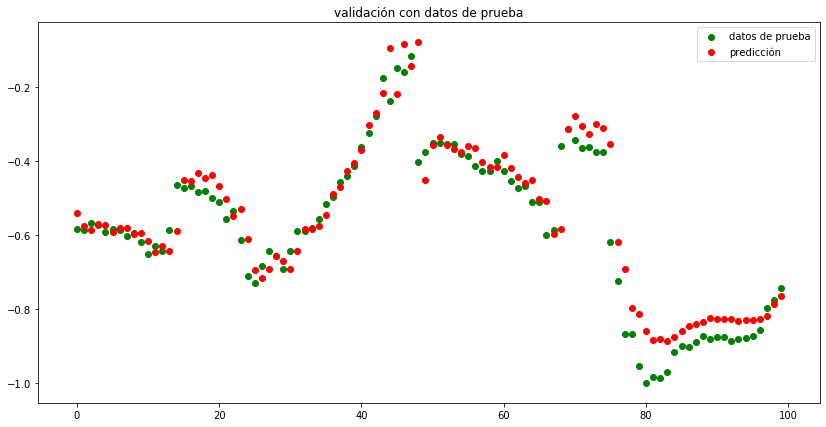

In [60]:
# validación modelo
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validación con datos de prueba')
plt.legend(['datos de prueba','predicción'])
plt.show()

En principio se visualizan predicciones bastante acertadas

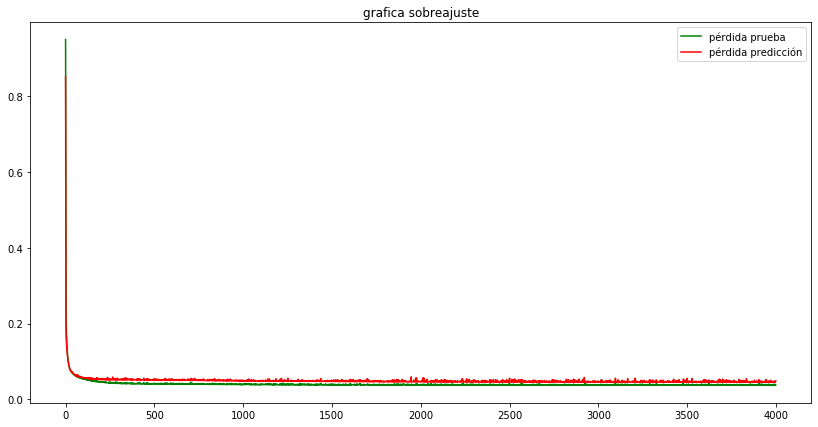

In [61]:
# revisión sobreajuste
plt.plot(history.history['loss'],c='g')
plt.plot(history.history['val_loss'],c='r')
plt.title('grafica sobreajuste')
plt.legend(['pérdida prueba','pérdida predicción'])
plt.show()

Dado este grafico se puede concluir como primera que impresión no hay sobreajuste, ya que las curvas no se superponen

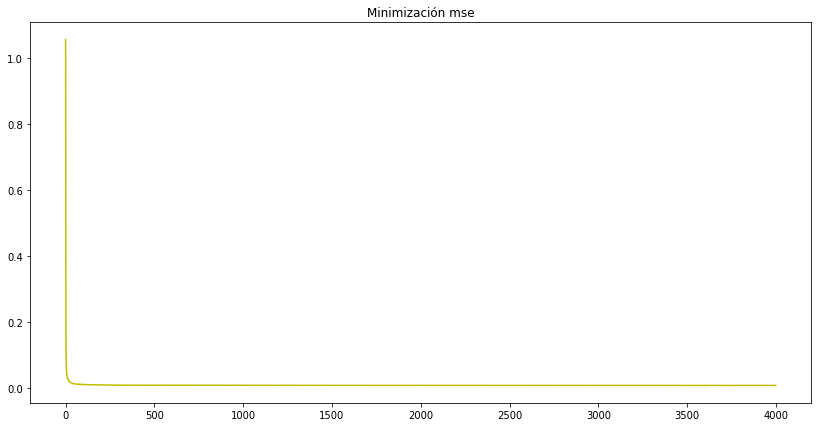

In [62]:
plt.title('Minimización mse')
plt.plot(history.history['mse'],color = 'y')
plt.show()

In [63]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

comparar = pd.DataFrame(inverted)
comparar.columns = ['real', 'prediccion']
comparar['diferencia'] = comparar['real'] - comparar['prediccion']
comparar

,real,prediccion,diferencia
0,208691.0,219140.062500,-10449.062500
1,207466.0,210341.406250,-2875.406250
2,212057.0,207905.218750,4151.781250
3,210838.0,211391.234375,-553.234375
4,206120.0,211301.812500,-5181.812500
...,...,...,...
95,136838.0,147529.937500,-10691.937500
96,140861.0,148271.718750,-7410.718750
97,155719.0,150289.437500,5429.562500
98,160614.0,158509.687500,2104.312500


In [64]:
comparar.describe()

,real,prediccion,diferencia
count,100.000000,100.000000,100.000000
mean,210260.156250,217111.625000,-6851.403809
std,52690.246094,50504.902344,16465.914062
min,105625.000000,133670.828125,-79662.187500
25%,176324.500000,181642.097656,-12687.253906
50%,209999.000000,211346.523438,-5434.281250
75%,250282.234375,252813.941406,1723.019531
max,324189.000000,333172.187500,55705.265625


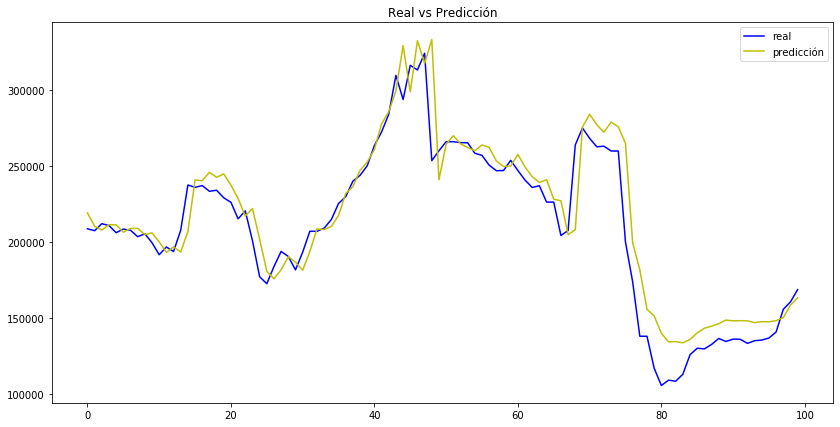

In [65]:
plt.title('Real vs Predicción')
comparar['real'].plot(color = 'b')
comparar['prediccion'].plot(c = 'y')
plt.legend(['real','predicción'])

In [66]:
LastWeeks = df['2020-09-26':'2020-12-26']
LastWeeks

fecha
2020-09-26    129722
2020-10-03    132629
2020-10-10    136556
2020-10-17    134595
2020-10-24    136131
2020-10-31    136025
2020-11-07    133328
2020-11-14    135087
2020-11-21    135522
2020-11-28    136838
2020-12-05    140861
2020-12-12    155719
2020-12-19    160614
2020-12-26    168726
Name: kg, dtype: int64

In [67]:
values = LastWeeks.values
values = values.astype('float32')
values
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,-0.850938,-0.649574,-0.750128,-0.671367,-0.676802,-0.815096
8,-0.850938,-0.649574,-0.750128,-0.671367,-0.676802,-0.815096,-0.724900
9,-0.649574,-0.750128,-0.671367,-0.676802,-0.815096,-0.724900,-0.702594
10,-0.750128,-0.671367,-0.676802,-0.815096,-0.724900,-0.702594,-0.635114
11,-0.671367,-0.676802,-0.815096,-0.724900,-0.702594,-0.635114,-0.428828
12,-0.676802,-0.815096,-0.724900,-0.702594,-0.635114,-0.428828,0.333043
13,-0.815096,-0.724900,-0.702594,-0.635114,-0.428828,0.333043,0.584043


In [68]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)

(1, 1, 7)


In [69]:
x_test

array([[[-0.8150959 , -0.72489977, -0.7025943 , -0.6351142 ,
         -0.42882776,  0.3330431 ,  0.58404255]]], dtype=float32)

In [70]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1] = nuevoValor
    return x_test

In [71]:
results = []
for i in range(7):
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test,parcial[0])

[[[-0.8150959  -0.72489977 -0.7025943  -0.6351142  -0.42882776
    0.3330431   0.58404255]]]
[[[-0.72489977 -0.7025943  -0.6351142  -0.42882776  0.3330431
    0.58404255  0.6061136 ]]]
[[[-0.7025943  -0.6351142  -0.42882776  0.3330431   0.58404255
    0.6061136   0.47402093]]]
[[[-0.6351142  -0.42882776  0.3330431   0.58404255  0.6061136
    0.47402093  0.12418203]]]
[[[-0.42882776  0.3330431   0.58404255  0.6061136   0.47402093
    0.12418203 -0.14553662]]]
[[[ 0.3330431   0.58404255  0.6061136   0.47402093  0.12418203
   -0.14553662 -0.19569886]]]
[[[ 0.58404255  0.6061136   0.47402093  0.12418203 -0.14553662
   -0.19569886 -0.16561975]]]


In [72]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.6061136], dtype=float32), array([0.47402093], dtype=float32), array([0.12418203], dtype=float32), array([-0.14553662], dtype=float32), array([-0.19569886], dtype=float32), array([-0.16561975], dtype=float32), array([-0.16570503], dtype=float32)]


array([[161044.424176  ],
       [158468.35258903],
       [151645.79426609],
       [146385.74110259],
       [145407.47706089],
       [145994.07990475],
       [145992.41678692]])

Text(0.5, 1.0, 'Primeras 7 semanas 2021')

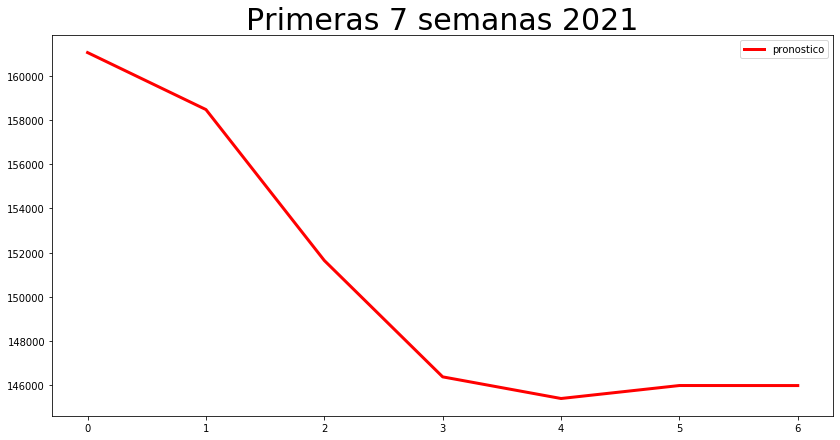

In [73]:
prediccion2021 = pd.DataFrame(inverted)
prediccion2021.columns = ['pronostico']
prediccion2021.plot(c='r',linewidth=3)
plt.title('Primeras 7 semanas 2021',size=30)
#prediccion2021.to_excel('pronosticoBRIO-80-20-4000.xlsx')

In [74]:
prediccion2021

,pronostico
0,161044.424176
1,158468.352589
2,151645.794266
3,146385.741103
4,145407.477061
5,145994.079905
6,145992.416787


In [75]:
i=2
for fila in prediccion2021.pronostico:
    
    LastWeeks.loc['2021'+ '-1-' + str(i) + ' 00:00:00'] = fila
    i=i+7
    print(fila)
LastWeeks.tail(14)

161044.42417599555
158468.35258903302
151645.79426609294
146385.74110258798
145407.47706088822
145994.07990474824
145992.4167869174


fecha
2020-11-14 00:00:00    135087.000000
2020-11-21 00:00:00    135522.000000
2020-11-28 00:00:00    136838.000000
2020-12-05 00:00:00    140861.000000
2020-12-12 00:00:00    155719.000000
2020-12-19 00:00:00    160614.000000
2020-12-26 00:00:00    168726.000000
2021-1-2 00:00:00      161044.424176
2021-1-9 00:00:00      158468.352589
2021-1-16 00:00:00     151645.794266
2021-1-23 00:00:00     146385.741103
2021-1-30 00:00:00     145407.477061
2021-1-37 00:00:00     145994.079905
2021-1-44 00:00:00     145992.416787
Name: kg, dtype: float64

In [76]:
LastWeeks

fecha
2020-09-26 00:00:00    129722.000000
2020-10-03 00:00:00    132629.000000
2020-10-10 00:00:00    136556.000000
2020-10-17 00:00:00    134595.000000
2020-10-24 00:00:00    136131.000000
2020-10-31 00:00:00    136025.000000
2020-11-07 00:00:00    133328.000000
2020-11-14 00:00:00    135087.000000
2020-11-21 00:00:00    135522.000000
2020-11-28 00:00:00    136838.000000
2020-12-05 00:00:00    140861.000000
2020-12-12 00:00:00    155719.000000
2020-12-19 00:00:00    160614.000000
2020-12-26 00:00:00    168726.000000
2021-1-2 00:00:00      161044.424176
2021-1-9 00:00:00      158468.352589
2021-1-16 00:00:00     151645.794266
2021-1-23 00:00:00     146385.741103
2021-1-30 00:00:00     145407.477061
2021-1-37 00:00:00     145994.079905
2021-1-44 00:00:00     145992.416787
Name: kg, dtype: float64